# General purpose code

# Package

In [1]:
# ! pip install pydicom
# ! pip install roipoly
# ! pip install PyQt5
# ! pip install install ipython==7.10.0
# !pip install pylibjpeg pylibjpeg-libjpeg pydicom
# !pip install python-gdcm
# !pip install mahotas

In [2]:
#! pip install -U scikit-learn

In [2]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.filterwarnings("ignore", category=RuntimeWarning) 

In [3]:
import numpy as np
import matplotlib.pyplot as plt

#Path
import os, os.path
import pickle
import shutil
import glob

#Modeling
from sklearn.cluster import KMeans 
from sklearn.cluster import DBSCAN 
from sklearn.decomposition import PCA
from sklearn import svm, datasets
from sklearn.metrics import auc
from sklearn.metrics import plot_roc_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import BaggingClassifier
from sklearn.datasets import make_classification

# Scipy
from scipy.misc import face
from scipy import ndimage as ndi
from skimage.morphology import ball, disk, dilation, binary_erosion, remove_small_objects, erosion, closing, reconstruction, binary_closing
from skimage.segmentation import clear_border, mark_boundaries
from skimage.filters import roberts, sobel
from scipy.signal.signaltools import wiener

#Image
import cv2
from PIL import Image
import matplotlib.pyplot as plt

#Medical Image
import pydicom
from pydicom import dcmread
from pydicom.data import get_testdata_file
from roipoly import RoiPoly
import mahotas
import mahotas.demos
import mahotas as mh
import numpy as np
from pylab import imshow, show

# ipywidgets for some interactive plots
from ipywidgets.widgets import * 
import ipywidgets as widgets

# 1. Prepare the dataset

For each patient exam we select the scans at the 33rd, 41st and 49th percentile of the total number of available scans: the idea is to isolate the most representative slices.

## 1.1 Read and select image of positive patient

In [16]:
negative_path = "user\manifest-1612365584013\MIDRC-RICORD-1B"
output_path = "user\CT_DATA"

In [17]:
lista1 = glob.glob(negative_path + "\\" + "MIDRC*")

In [19]:
idx = 0

for general_path in lista1:
    
    lista2 = glob.glob(general_path + "\\" + "*")
    lista3 = glob.glob(lista2[0] + "\\" + "*")

    for path in lista3:
        list_idx = []
        idx += 1
        lista_tmp = glob.glob(path + "\\" + "*.dcm")
        n_dcm = len(lista_tmp)
        if n_dcm > 50:
            n_dcm_interval = int(n_dcm / 12)
            list_idx = [n_dcm_interval*4, n_dcm_interval*5, n_dcm_interval*6]
            for idx_elem in list_idx:
                path_img = glob.glob(path + "\\" + "*" + str(idx_elem) + ".dcm")
                img_name = path_img[0].split("\\")[-1].split("-")[-1]
                img_name2 = "negative" + "-" + str(idx) + "-" + img_name 
                shutil.copy(path_img[0], output_path + "\\" + img_name2)

## 1.2 Read and select image of positive patient

In [20]:
positive_path = "user\manifest-1608266677008\MIDRC-RICORD-1A"
output_path = "user\CT_DATA"

In [21]:
lista1 = glob.glob(positive_path + "\\" + "MIDRC*")

In [23]:
lista_stop = ["SAG","COR","sag", "cor"]

In [24]:
idx = 0

for general_path in lista1:
    
    lista2 = glob.glob(general_path + "\\" + "*")
    lista3 = glob.glob(lista2[0] + "\\" + "*")

    for path in lista3:

        control_list = sum([x in path.split("\\")[-1] for x in lista_stop])
        
        if control_list == 0:
        
            list_idx = []
            idx += 1
            lista_tmp = glob.glob(path + "\\" + "*.dcm")
            n_dcm = len(lista_tmp)
            if n_dcm > 50:
                n_dcm_interval = int(n_dcm / 12)
                list_idx = [n_dcm_interval*4, n_dcm_interval*5, n_dcm_interval*6]
                for idx_elem in list_idx:
                    path_img = glob.glob(path + "\\" + "*" + str(idx_elem) + ".dcm")
                    img_name = path_img[0].split("\\")[-1].split("-")[-1]
                    img_name2 = "positive" + "-" + str(idx) + "-" + img_name 
                    shutil.copy(path_img[0], output_path + "\\" + img_name2)

# 2. Read a single CT image (.dicom files)

In [35]:
path = "user\CT_DATA"

In [36]:
dcm = dcmread(path + '\\negative-15-105.dcm')

In [37]:
dcm

Dataset.file_meta -------------------------------
(0002, 0000) File Meta Information Group Length  UL: 208
(0002, 0001) File Meta Information Version       OB: b'\x00\x01'
(0002, 0002) Media Storage SOP Class UID         UI: CT Image Storage
(0002, 0003) Media Storage SOP Instance UID      UI: 1.2.826.0.1.3680043.10.474.419639.220506860253404869402793635193
(0002, 0010) Transfer Syntax UID                 UI: JPEG Lossless, Non-Hierarchical, First-Order Prediction (Process 14 [Selection Value 1])
(0002, 0012) Implementation Class UID            UI: 1.3.6.1.4.1.22213.1.143
(0002, 0013) Implementation Version Name         SH: '0.5'
(0002, 0016) Source Application Entity Title     AE: 'POSDA'
-------------------------------------------------
(0008, 0005) Specific Character Set              CS: 'ISO_IR 100'
(0008, 0008) Image Type                          CS: ['ORIGINAL', 'PRIMARY', 'AXIAL']
(0008, 0016) SOP Class UID                       UI: CT Image Storage
(0008, 0018) SOP Instance UID

In [12]:
img = dcm.pixel_array
img = img*dcm.RescaleSlope

## 2.1 Show the selected image

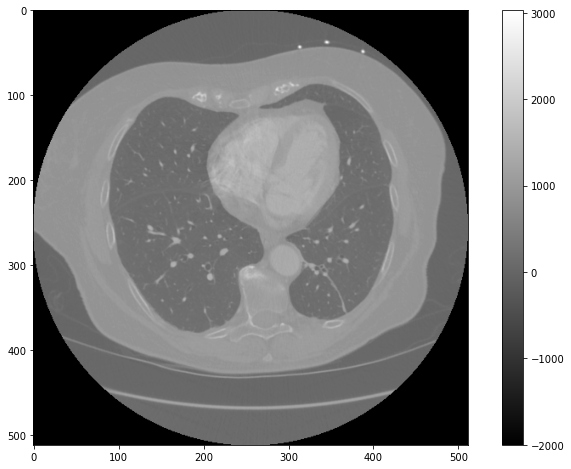

In [13]:
plt.figure(figsize =(12,8))
plt.imshow(img, cmap=plt.cm.gray)
plt.colorbar()

## 2.2 Slider for all the image in the path

In [3]:
path_exam = "exam_folder"

In [4]:
def dicom_animation(x):
    plt.figure(1, figsize=(12,10))
    plt.imshow(m[x], cmap=plt.cm.gray)
    return x

In [5]:
files = sorted(os.listdir(path_exam))
m = np.zeros((len(files), 512, 512))
for n in range(0,len(files)):
    pathtemp = path_exam + "\\" + files[n]
    dcm = dcmread(pathtemp)
    img = dcm.pixel_array
    img = img*dcm.RescaleSlope
    m[n, : , : ] = img

In [6]:
interact(dicom_animation, x=(0, len(m)-1))

interactive(children=(IntSlider(value=127, description='x', max=254), Output()), _dom_classes=('widget-interac…

<function __main__.dicom_animation(x)>

## 2.3 Single image analysis 

In [20]:
def load_and_preprocess_dcm(path):
    
    ds = dcmread(path)
    img = ds.pixel_array
    img = ds.RescaleIntercept + img * ds.RescaleSlope
    minimum = np.amin(np.amin(img))
    maximum = np.amax(np.amax(img))
    img[img == minimum] = -1000
    # Normalization
    img = (img - minimum) / maximum
    new_img = ((img - img.min()) * (1/(img.max() - img.min()) * 255)).astype('uint8')
    new_img = new_img[50:460,30:480]
    
    return new_img

In [21]:
img = load_and_preprocess_dcm(path + '\\positive-2-105.dcm')

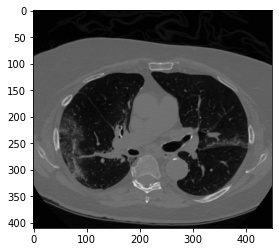

In [22]:
plt.imshow(img, cmap=plt.cm.gray)

## 2.4 Lung segmentation with k-means

In [23]:
def mask_kmeans(img_array):
    
    img_reshaped = img_array.reshape(-1,1)
    kmeans = KMeans(n_clusters = 2, random_state = 99).fit(img_reshaped)
    kmeans_y = kmeans.fit_predict(img_reshaped)
    lab = kmeans.labels_
    mask = lab.reshape(img_array.shape)
    
    # Control the mask
    if mask[1,1] == 0:
        mask = abs(mask-1)

    return mask

In [24]:
first_mask = mask_kmeans(img)

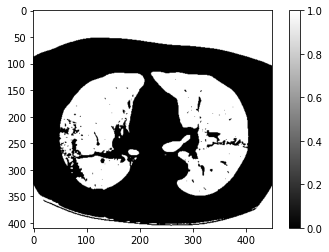

In [25]:
plt.imshow(first_mask, cmap=plt.cm.gray)
plt.colorbar()

## 2.5 Skimage Fill Mask

In [34]:
def fill_mask(first_mask):
    
    cleared = clear_border(first_mask)

    selem = disk(1.5)
    binary = binary_erosion(cleared, selem)

    selem = disk(10)
    binary = binary_closing(binary, selem)

    edges = roberts(binary)
    binary = ndi.binary_fill_holes(edges)
    final_mask = binary.astype('uint8')

    return final_mask

In [35]:
final_mask = fill_mask(first_mask)

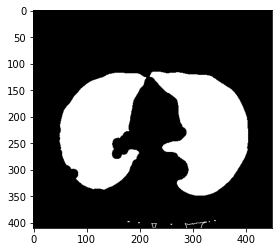

In [36]:
plt.imshow(final_mask, cmap=plt.cm.gray)

## 2.6 Equalize and Wiener Filter to Image

In [37]:
dst = cv2.equalizeHist(img*final_mask)

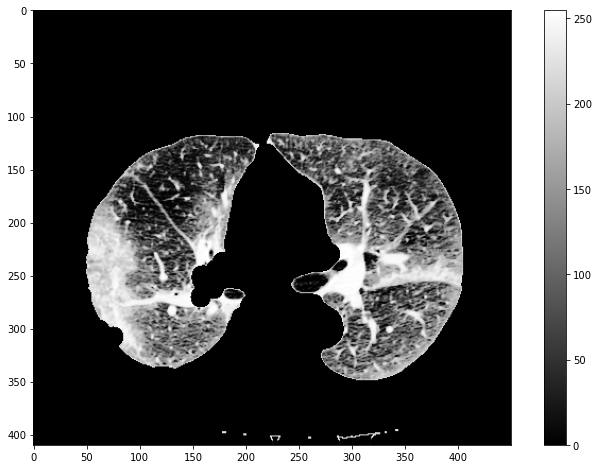

In [38]:
plt.figure(figsize =(12,8))
plt.imshow(dst,cmap=plt.cm.gray)
plt.colorbar()

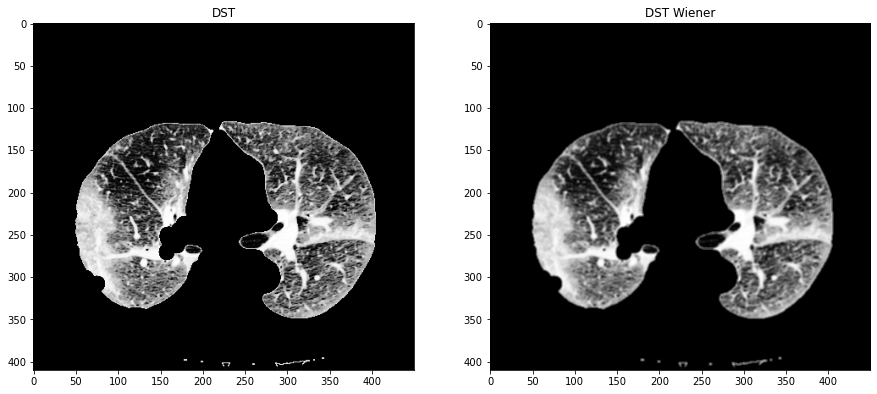

In [39]:
filtered_img = wiener(dst, (3, 3), noise=10)  #Filter the image

fig, ([ax1, ax2]) = plt.subplots(1,2, figsize=(15,12))
ax1.imshow(dst, cmap=plt.cm.gray)
ax1.set_title("DST")
ax2.imshow(filtered_img, cmap=plt.cm.gray)
ax2.set_title("DST Wiener")
plt.show()

## 2.7 Haralick features

In [42]:
def extract_haralick(img):
    
    # adding gaussian filter
    img_test = mahotas.gaussian_filter(img, .5, cval = 100, mode = "reflect")
    
    # setting threshold (threshed is the mask)
    threshed = (img_test > np.quantile(img_test[img_test!=0],.95))
    
    # making is labeled image
    feature_map, n = mahotas.label(threshed)

    # getting haralick features
    h_feature = mahotas.features.haralick(feature_map, distance = 2)    
    
    return feature_map, h_feature

In [43]:
feature_map, h_feature = extract_haralick(filtered_img)

Labelled Image


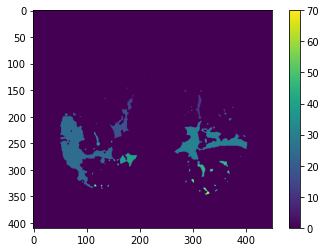

In [44]:
print("Labelled Image")
imshow(feature_map, cmap=plt.cm.viridis)
plt.colorbar()
show()

Haralick Features


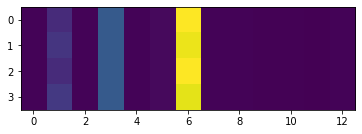

In [45]:
# showing the feature
print("Haralick Features")
imshow(h_feature,cmap=plt.cm.viridis)
plt.show()

In [49]:
h_feature

array([[ 8.87099457e-01,  1.73478332e+01,  7.84750256e-01,
         4.02969891e+01,  9.83544810e-01,  2.79771341e+00,
         1.43840123e+02,  5.13666072e-01,  5.33209825e-01,
         1.34246087e-02,  1.85997747e-01, -6.83744064e-01,
         6.52175254e-01],
       [ 8.81926650e-01,  2.18257506e+01,  7.30445683e-01,
         4.04848842e+01,  9.78550632e-01,  2.81142770e+00,
         1.40113786e+02,  5.38760219e-01,  5.63618589e-01,
         1.32864185e-02,  2.27924170e-01, -6.14221766e-01,
         6.27091437e-01],
       [ 8.88122298e-01,  1.69784096e+01,  7.89421316e-01,
         4.03136947e+01,  9.84671375e-01,  2.79893246e+00,
         1.44276369e+02,  5.06778143e-01,  5.25538054e-01,
         1.34558768e-02,  1.71282381e-01, -7.03143584e-01,
         6.59096977e-01],
       [ 8.81198840e-01,  2.35258119e+01,  7.09449436e-01,
         4.04848842e+01,  9.77825011e-01,  2.81142770e+00,
         1.38413725e+02,  5.42458541e-01,  5.67943974e-01,
         1.32665804e-02,  2.35631004e

In [50]:
h_feature.shape

(4, 13)

# 3 Pipeline

In [51]:
data_path = "user\CT_DATA"

In [52]:
lista_path_img = glob.glob(data_path + "\\" + "*.dcm")

In [53]:
lista_path_img[0:5]

['C:\\Users\\matti\\Desktop\\CT_DATA\\negative-1-072.dcm',
 'C:\\Users\\matti\\Desktop\\CT_DATA\\negative-1-090.dcm',
 'C:\\Users\\matti\\Desktop\\CT_DATA\\negative-1-108.dcm',
 'C:\\Users\\matti\\Desktop\\CT_DATA\\negative-10-088.dcm',
 'C:\\Users\\matti\\Desktop\\CT_DATA\\negative-10-110.dcm']

Define a function that for a single patien, read the images, preprocess the selected images, segment the lungs and extraxt the haralick features. At the end, a plot with all the figure are shown.

In [54]:
def features_and_plot(id_pat, label, printing=False):
        
    print("The patient ID is: " + str(id_pat))
    
    id_feat_list = []
    
    for path_img in lista_path_img:
        
        read_label = path_img.split("\\")[-1].split("-")[0]
        read_id_pat = path_img.split("\\")[-1].split("-")[1]
        
        if read_label == label and read_id_pat == id_pat:
            
            # Read img
            img = load_and_preprocess_dcm(path_img)            
            row, col = img.shape
           
            # Lung segmentation
            first_mask = mask_kmeans(img)
            
            # Fill the mask Skimage
            final_mask = fill_mask(first_mask)
            
            # Control the mask
            n_0 = len(final_mask[final_mask==0])
            n_1 = len(final_mask[final_mask==1])
            if (n_1/(n_0 + n_1)) < 0.1 or (n_1/(n_0 + n_1)) > 0.9:
                print("The selected scans are not good enough")
                return np.array([])

            # Equalized hist of image
            dst = cv2.equalizeHist(img*final_mask)
            # Wiener filter
            filtered_img = wiener(dst, (3, 3), noise=10)

            # Extract Haralick Features
            feature_map, h_feature = extract_haralick(filtered_img)
            
            #h_feature_reshaped = np.reshape(h_feature,-1)
            id_feat_list.append(h_feature)

            # showing the features
            if printing:
                fig, ([ax1, ax2, ax3], [ax4, ax5, ax6]) = plt.subplots(2,3, figsize=(12,10))
                ax1.imshow(img, cmap=plt.cm.gray)
                ax1.set_title("Original Image")
                ax2.imshow(first_mask, cmap=plt.cm.gray)
                ax2.set_title("Initial Mask")
                ax3.imshow(final_mask, cmap=plt.cm.gray)
                ax3.set_title("Final Mask")
                ax4.imshow(dst, cmap=plt.cm.gray)
                ax4.set_title("Equalized image (Masked)")
                ax5.imshow(feature_map, cmap=plt.cm.viridis)
                ax5.set_title("Haralick Features Map")
                ax6.imshow(h_feature,cmap=plt.cm.viridis)
                ax6.set_title("Haralick Features Values")
                    
    return id_feat_list    

Call for a negative patient

The patient ID is: 2


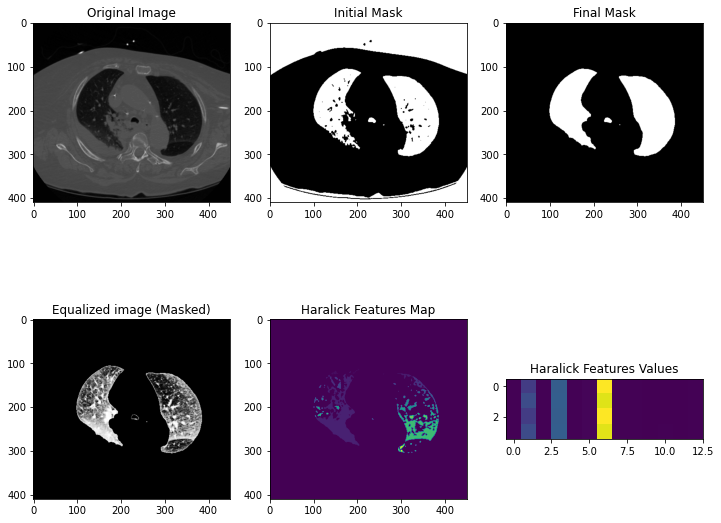

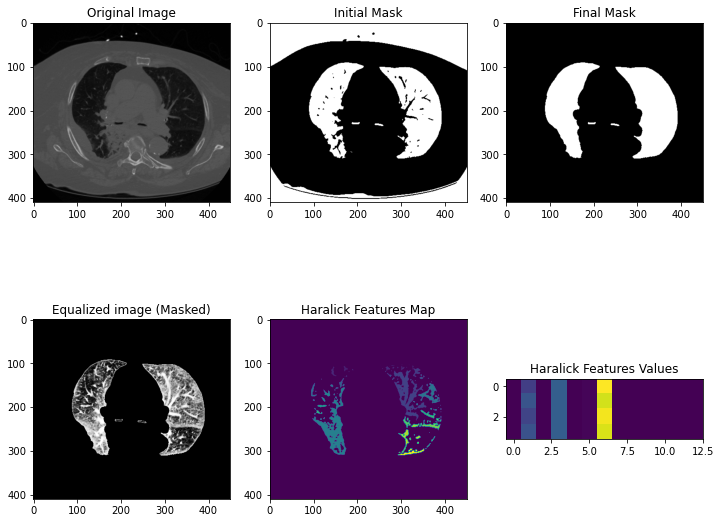

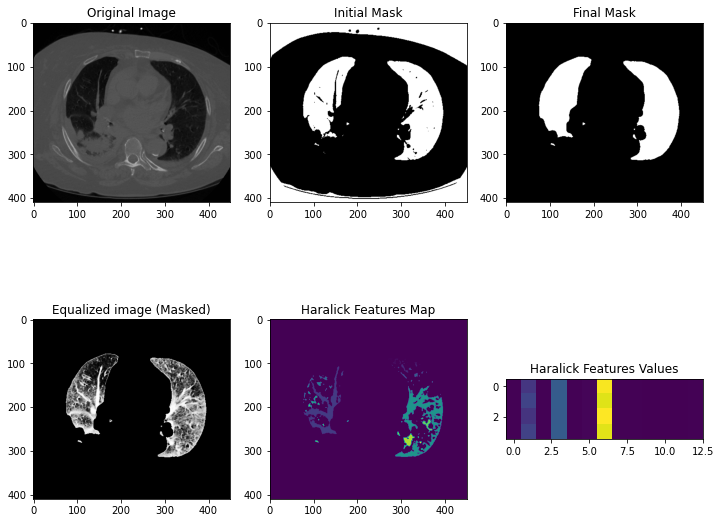

In [55]:
feat = features_and_plot(id_pat="2", label="negative", printing=True)

Call for a positive patient

The patient ID is: 2


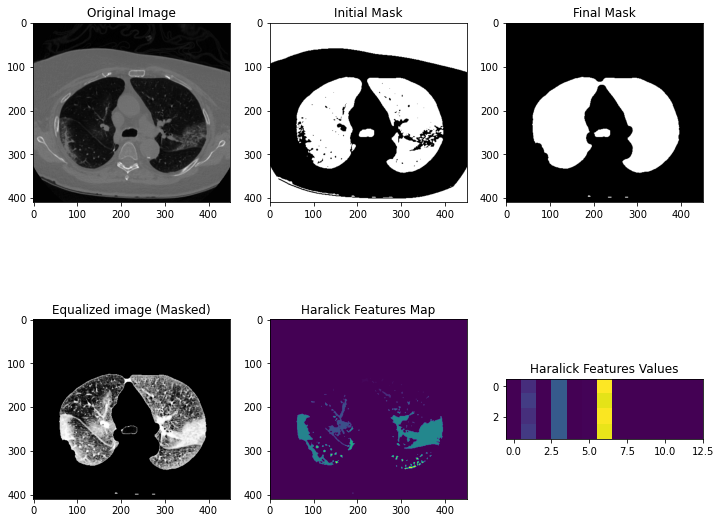

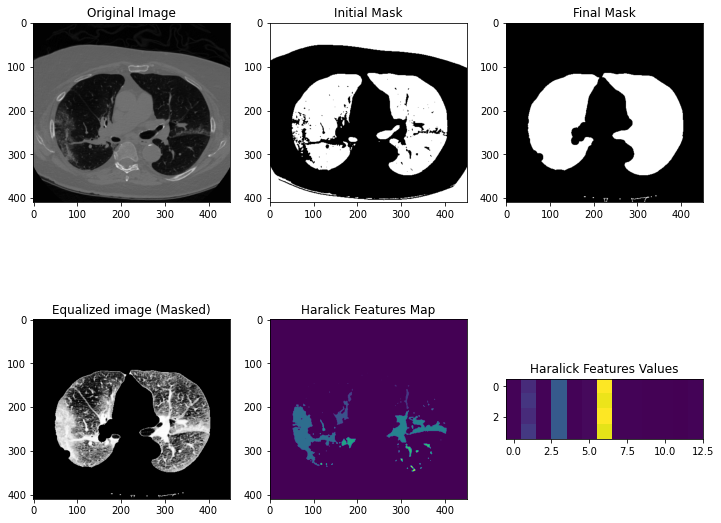

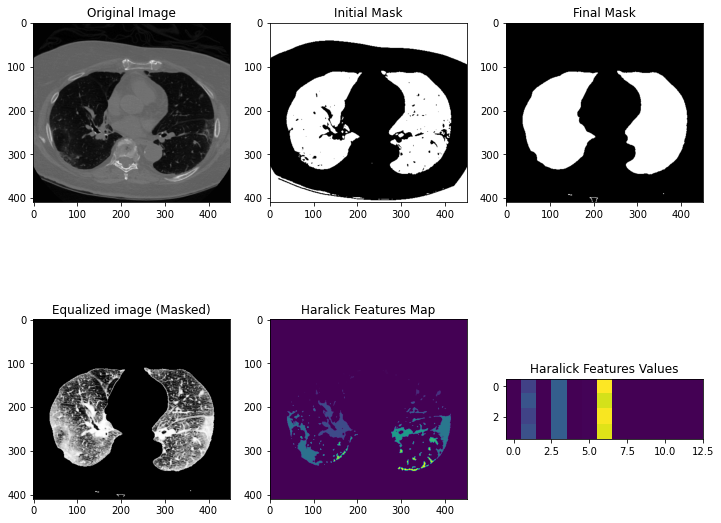

In [56]:
feat = features_and_plot(id_pat="2", label="positive", printing=True)

## 3.1 Apply the pipeline for all the positive patients

In [23]:
feat_positive = []
id_positive = np.arange(2,164)

for idx_positive in id_positive:
    feat = features_and_plot(id_pat = str(idx_positive), label="positive", printing=False)
    feat_positive.append(feat)

The patient ID is: 2
The patient ID is: 3
The patient ID is: 4
The patient ID is: 5
The patient ID is: 6
The patient ID is: 7
The patient ID is: 8
The patient ID is: 9
The patient ID is: 10
The patient ID is: 11
The patient ID is: 12
The patient ID is: 13
The patient ID is: 14
The patient ID is: 15
The patient ID is: 16
The patient ID is: 17
The patient ID is: 18
The patient ID is: 19
The patient ID is: 20
The patient ID is: 21
The patient ID is: 22
The patient ID is: 23
The patient ID is: 24
The patient ID is: 25
The patient ID is: 26
The patient ID is: 27
The patient ID is: 28
The patient ID is: 29
The patient ID is: 30
The selected scans are not good enough
The patient ID is: 31
The patient ID is: 32
The selected scans are not good enough
The patient ID is: 33
The patient ID is: 34
The selected scans are not good enough
The patient ID is: 35
The selected scans are not good enough
The patient ID is: 36
The selected scans are not good enough
The patient ID is: 37
The patient ID is: 38

In [43]:
len(feat_positive)

162

In [44]:
feat_positive2 = []
for elem in feat_positive:
    if len(elem) != 0:
        feat_positive2.append(elem)

In [50]:
file = open('feat_data_positive.pickle', 'wb')
pickle.dump(feat_positive2, file)

## 3.2 Apply the pipeline for all the negative patients

In [51]:
feat_negative = []
id_negative = np.arange(1,117)

for idx_negative in id_negative:
    feat = features_and_plot(id_pat = str(idx_negative), label="negative", printing=False)
    feat_negative.append(feat)

The patient ID is: 1
The patient ID is: 2
The patient ID is: 3
The patient ID is: 4
The patient ID is: 5
The patient ID is: 6
The patient ID is: 7
The patient ID is: 8
The patient ID is: 9
The patient ID is: 10
The selected scans are not good enough
The patient ID is: 11
The patient ID is: 12
The patient ID is: 13
The patient ID is: 14
The patient ID is: 15
The patient ID is: 16
The patient ID is: 17
The patient ID is: 18
The patient ID is: 19
The patient ID is: 20
The selected scans are not good enough
The patient ID is: 21
The patient ID is: 22
The patient ID is: 23
The patient ID is: 24
The patient ID is: 25
The patient ID is: 26
The patient ID is: 27
The patient ID is: 28
The patient ID is: 29
The patient ID is: 30
The selected scans are not good enough
The patient ID is: 31
The patient ID is: 32
The patient ID is: 33
The patient ID is: 34
The patient ID is: 35
The patient ID is: 36
The patient ID is: 37
The selected scans are not good enough
The patient ID is: 38
The selected scan

In [52]:
len(feat_negative)

116

In [53]:
feat_negative2 = []
for elem in feat_negative:
    if len(elem) != 0:
        feat_negative2.append(elem)

In [55]:
file = open('feat_data_negative.pickle', 'wb')
pickle.dump(feat_negative2, file)

In [59]:
len(feat_negative2) + len(feat_positive2)

238

## 3.4 Combine positive and negative patients and save the file

#### Data

In [60]:
data_feat = feat_positive2 + feat_negative2

In [65]:
file = open('feat_data.pickle', 'wb')
pickle.dump(data_feat, file)

#### Labels

In [72]:
list_1 = np.repeat(1, len(feat_positive2))
list_0 = np.repeat(0, len(feat_negative2))
labels = np.concatenate((list_1, list_0))

In [73]:
labels.shape

(238,)

In [74]:
file = open('labels.pickle', 'wb')
pickle.dump(labels, file)

## 3.3 Difference between features in positive and negative patients

In [76]:
pickle_in = open('feat_data_positive.pickle',"rb")
positive_data = pickle.load(pickle_in)

pickle_in = open('feat_data_negative.pickle',"rb")
negative_data = pickle.load(pickle_in)

In [154]:
i = 0
for pat in positive_data:
    for elem in pat:
        if i == 0:
            elem_pos = np.array((elem))
            i += 1
        else:
            elem_pos = np.concatenate((elem_pos, elem))

In [155]:
i = 0
for pat in negative_data:
    for elem in pat:
        if i == 0:
            elem_neg = np.array((elem))
            i += 1
        else:
            elem_neg = np.concatenate((elem_neg, elem))

In [158]:
elem_mean_pos = elem_pos.mean(axis=0)
elem_mean_neg = elem_neg.mean(axis=0)

In [159]:
elem_std_pos = elem_pos.std(axis=0)
elem_std_neg = elem_neg.std(axis=0)

In [168]:
cnt = 0
for idx in range(0,len(elem_neg)):
    print(str(cnt+1))
    print("Positive: " + '%.2f' % elem_mean_pos[idx] + "   " + '%.2f' % elem_std_pos[idx])
    print("Negative: " + '%.2f' % elem_mean_neg[idx] + "   " + '%.2f' % elem_std_neg[idx])
    print("\n")
    cnt += 1

1
Positive: 0.88   0.01
Negative: 0.87   0.01


2
Positive: 187.78   358.54
Negative: 400.08   428.23


3
Positive: 0.67   0.11
Negative: 0.61   0.10


4
Positive: 229.23   367.81
Negative: 454.47   426.57


5
Positive: 0.97   0.01
Negative: 0.97   0.01


6
Positive: 4.87   3.76
Negative: 7.55   4.15


7
Positive: 729.15   1121.47
Negative: 1417.79   1293.52


8
Positive: 0.62   0.10
Negative: 0.69   0.12


9
Positive: 0.65   0.11
Negative: 0.73   0.14


10
Positive: 0.01   0.01
Negative: 0.01   0.01


11
Positive: 0.30   0.11
Negative: 0.38   0.13


12
Positive: -0.57   0.09
Negative: -0.52   0.11


13
Positive: 0.63   0.03
Negative: 0.62   0.03


14


IndexError: index 13 is out of bounds for axis 0 with size 13

# 4. Training the model with all features PCA

## 4.1 Load the data

In [4]:
pickle_in = open('feat_data.pickle',"rb")
data = pickle.load(pickle_in)

In [5]:
pickle_in = open('labels.pickle',"rb")
labels = pickle.load(pickle_in)

## 4.2 PCA

In [7]:
lista=[]
for pat in data:
    lista_pat=[]
    for elem in pat:
        lista_pat.append(elem.reshape(-1))
    lista_pat = np.vstack(lista_pat)
    lista_pat = np.reshape(lista_pat, (156))
    lista.append(lista_pat)

In [9]:
data = np.array(lista)

In [10]:
data.shape

(238, 156)

In [25]:
pca = PCA(n_components=2)
scatter_plot_points = pca.fit_transform(data)

In [13]:
print(pca.explained_variance_ratio_)

[0.7001905  0.19075148]


In [14]:
sum(pca.explained_variance_ratio_)

0.8909419860416506

In [15]:
print(pca.singular_values_)

[61256.30326532 31972.50306672]


#### Save PCA object

In [26]:
#file = open('pca.pickle', 'wb')
#pickle.dump(pca, file)

### 4.2.1 Plotting the PCA

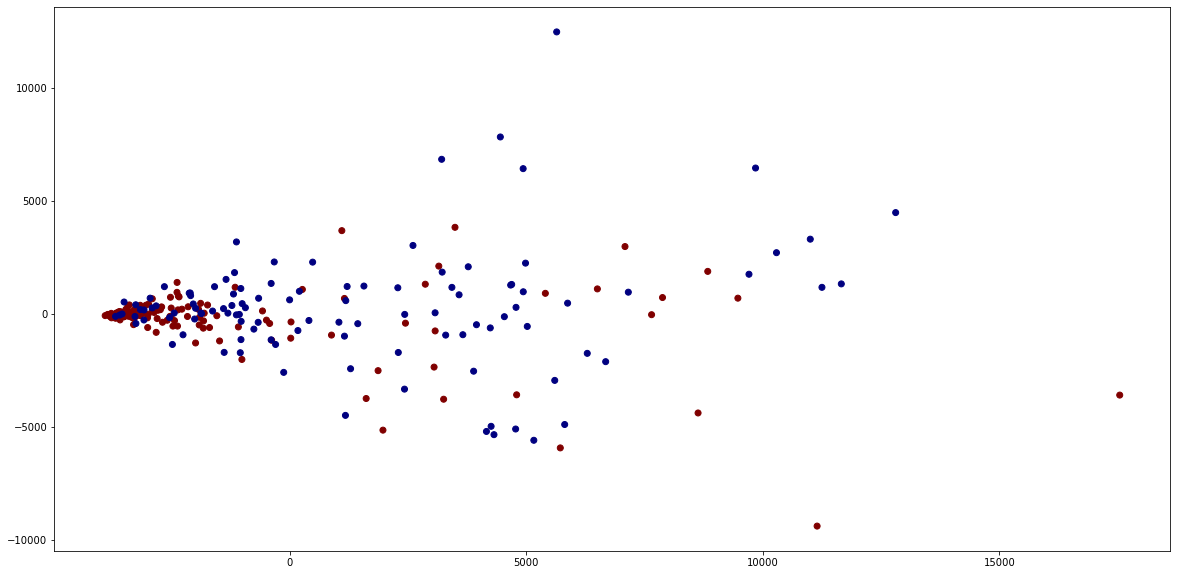

In [16]:
x_axis = [o[0] for o in scatter_plot_points]
y_axis = [o[1] for o in scatter_plot_points]
fig, ax = plt.subplots(figsize=(20,10))
#ax.set_xlim(-0.05e7, 0.1e7)
#ax.set_ylim(-0.5e6, 0.2e6)
ax.scatter(x_axis, y_axis, c=labels, cmap='jet')

## 4.3 Train/Test Split

In [17]:
X_train, X_test, y_train, y_test = train_test_split(scatter_plot_points, 
                                                    labels, 
                                                    test_size = 0.20, 
                                                    random_state = 22, 
                                                    shuffle = True, 
                                                    stratify = labels)

## 4.4 Modeling

### 4.4.1 SVC

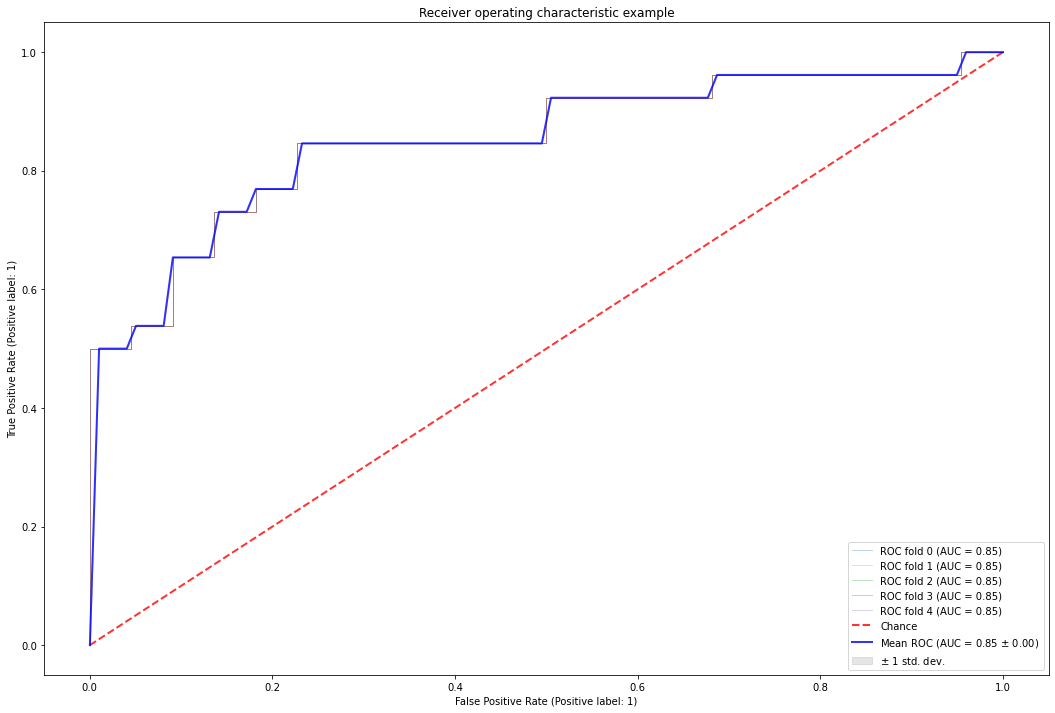

In [28]:
# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=5)
classifier_svc = svm.SVC(kernel='linear', probability=True,
                     random_state=42)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 3 , box.height * 3])
for i, (train, test) in enumerate(cv.split(X_train, y_train)):
    clf_svc = SVC(C=2, probability=True).fit(X_train, y_train) 
    y_pred = clf_svc.predict(X_test)
    viz = plot_roc_curve(clf_svc, X_test, y_test,
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic example")
ax.legend(loc="lower right")
plt.show()

In [29]:
# Classification Report
report_svc = classification_report(y_test, y_pred, output_dict = True)
accuracy_score(y_pred, y_test)

0.8125

[[17  5]
 [ 4 22]]


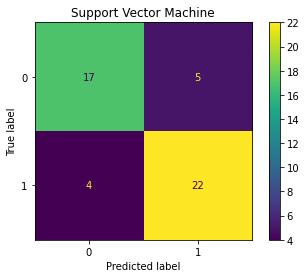

In [30]:
disp = plot_confusion_matrix(clf_svc, X_test, y_test, normalize=None) # attenzione all'argomento "normalize".
disp.ax_.set_title ("Support Vector Machine" ) 
print(disp.confusion_matrix )
plt.show ()

In [31]:
print(report_svc)

{'0': {'precision': 0.8095238095238095, 'recall': 0.7727272727272727, 'f1-score': 0.7906976744186046, 'support': 22}, '1': {'precision': 0.8148148148148148, 'recall': 0.8461538461538461, 'f1-score': 0.830188679245283, 'support': 26}, 'accuracy': 0.8125, 'macro avg': {'precision': 0.8121693121693121, 'recall': 0.8094405594405594, 'f1-score': 0.8104431768319438, 'support': 48}, 'weighted avg': {'precision': 0.812389770723104, 'recall': 0.8125, 'f1-score': 0.8120886353663886, 'support': 48}}


#### Save the model

In [34]:
#file = open('svc_pca_classifier.pickle', 'wb')
#pickle.dump(clf_svc, file)

### 4.4.2 Logistic Regression

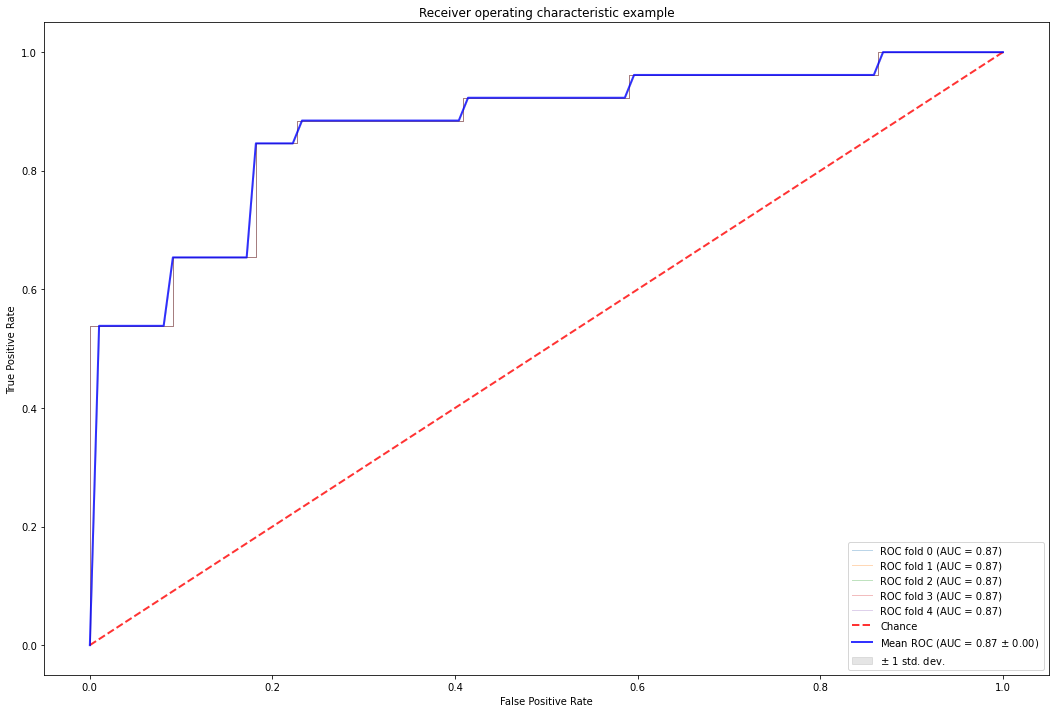

In [277]:
# CLASSIFICAZIONE PER LOGISTIC REGRESSION CROSS-VALIDATA

# Run classifier with cross-validation and plot ROC curves
classifier_log = LogisticRegression(penalty = 'l2',random_state=99)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 3 , box.height * 3])
for i, (train, test) in enumerate(cv.split(X_train, y_train)):
    clf_log = classifier_log.fit(X_train, y_train)  
    y_pred_log = clf_log.predict(X_test)
    viz = plot_roc_curve(clf_log, X_test, y_test,
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic example")
ax.legend(loc="lower right")
plt.show()

In [278]:
## Valutazione della classificzione LOGISTIC REGRESSION
#Accuracy

# Classification Report
report_log = classification_report(y_test, y_pred_log, output_dict = True)
accuracy_score(y_pred_log, y_test)

0.6875

[[ 9 13]
 [ 2 24]]


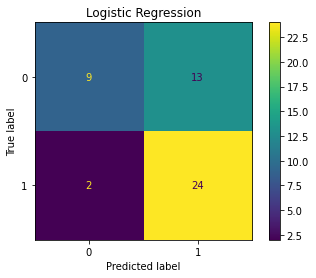

In [279]:
# Alternativa più completa
disp_log = plot_confusion_matrix(clf_log, X_test, y_test, normalize=None) # attenzione all'argomento "normalize".
disp_log.ax_.set_title ("Logistic Regression" ) 
print(disp_log.confusion_matrix )
plt.show()

## Bagging with SVC

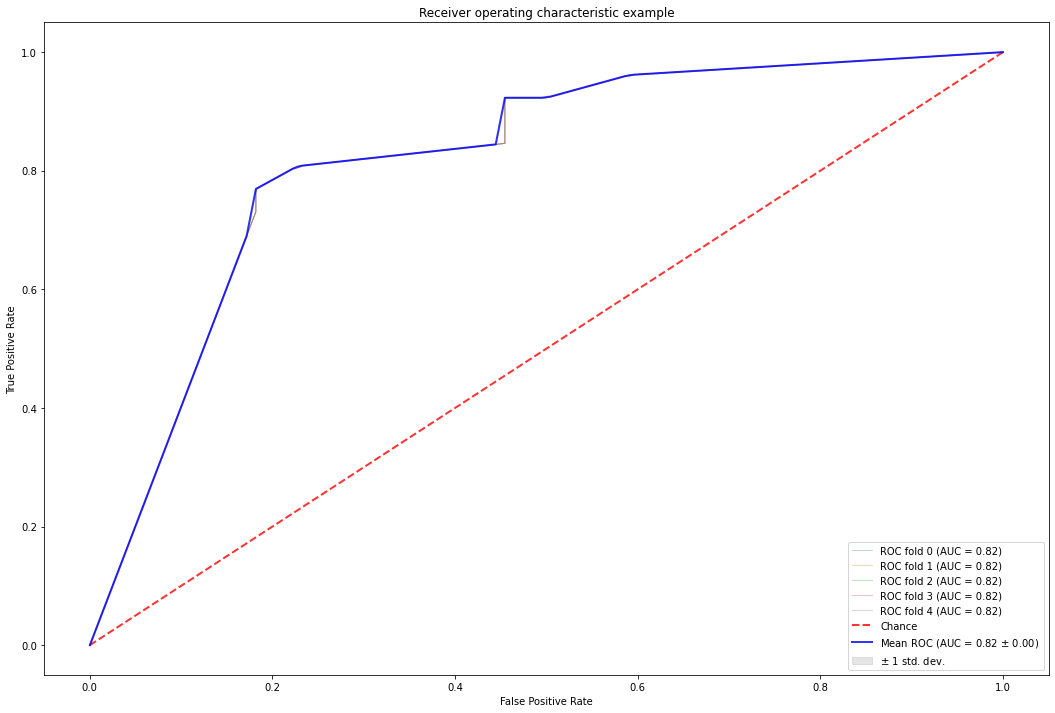

In [281]:
# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=5)
classifier_svc = svm.SVC(kernel='linear', probability=True,
                     random_state=42)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 3 , box.height * 3])
for i, (train, test) in enumerate(cv.split(X_train, y_train)):
    clf = BaggingClassifier(base_estimator=SVC(),
                         n_estimators=10, random_state=0).fit(X_train, y_train) 
    y_pred = clf.predict(X_test)
    viz = plot_roc_curve(clf, X_test, y_test,
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic example")
ax.legend(loc="lower right")
plt.show()

In [282]:
# Classification Report
report_svc = classification_report(y_test, y_pred, output_dict = True)
accuracy_score(y_pred, y_test)

0.7916666666666666

[[17  5]
 [ 5 21]]


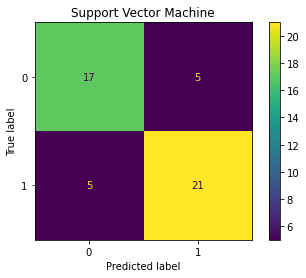

In [283]:
disp = plot_confusion_matrix(clf, X_test, y_test, normalize=None) # attenzione all'argomento "normalize".
disp.ax_.set_title ("Support Vector Machine" ) 
print(disp.confusion_matrix )
plt.show ()

In [284]:
print(report_svc)

{'0': {'precision': 0.7727272727272727, 'recall': 0.7727272727272727, 'f1-score': 0.7727272727272727, 'support': 22}, '1': {'precision': 0.8076923076923077, 'recall': 0.8076923076923077, 'f1-score': 0.8076923076923077, 'support': 26}, 'accuracy': 0.7916666666666666, 'macro avg': {'precision': 0.7902097902097902, 'recall': 0.7902097902097902, 'f1-score': 0.7902097902097902, 'support': 48}, 'weighted avg': {'precision': 0.7916666666666666, 'recall': 0.7916666666666666, 'f1-score': 0.7916666666666666, 'support': 48}}


# 5. Training the model with all features

## 5.1 Load the data

In [3]:
pickle_in = open('feat_data.pickle',"rb")
data = pickle.load(pickle_in)

In [4]:
pickle_in = open('labels.pickle',"rb")
labels = pickle.load(pickle_in)

In [8]:
np.mean(data[0][0],axis=0)

array([ 8.81697577e-01,  8.26205779e+01,  7.28980123e-01,  1.52380266e+02,
        9.78104908e-01,  5.38009193e+00,  5.26900487e+02,  5.62129019e-01,
        5.88532967e-01,  7.64870998e-03,  2.52109540e-01, -6.05402278e-01,
        6.32040673e-01])

In [10]:
lista=[]
for pat in data:
    lista_pat=[]
    for elem in pat:
        mean_elem = np.mean(elem,axis=0)
        lista_pat.append(mean_elem)
    lista_pat = np.vstack(lista_pat)
    lista_pat = np.reshape(lista_pat, (39))
    lista.append(lista_pat)

In [11]:
data = np.array(lista)

In [12]:
data.shape

(238, 39)

## 5.2 Train/Test Split

In [13]:
X_train, X_test, y_train, y_test = train_test_split(data, 
                                                    labels, 
                                                    test_size = 0.20, 
                                                    random_state = 22, 
                                                    shuffle = True, 
                                                    stratify = labels)

## 5.3 Modeling

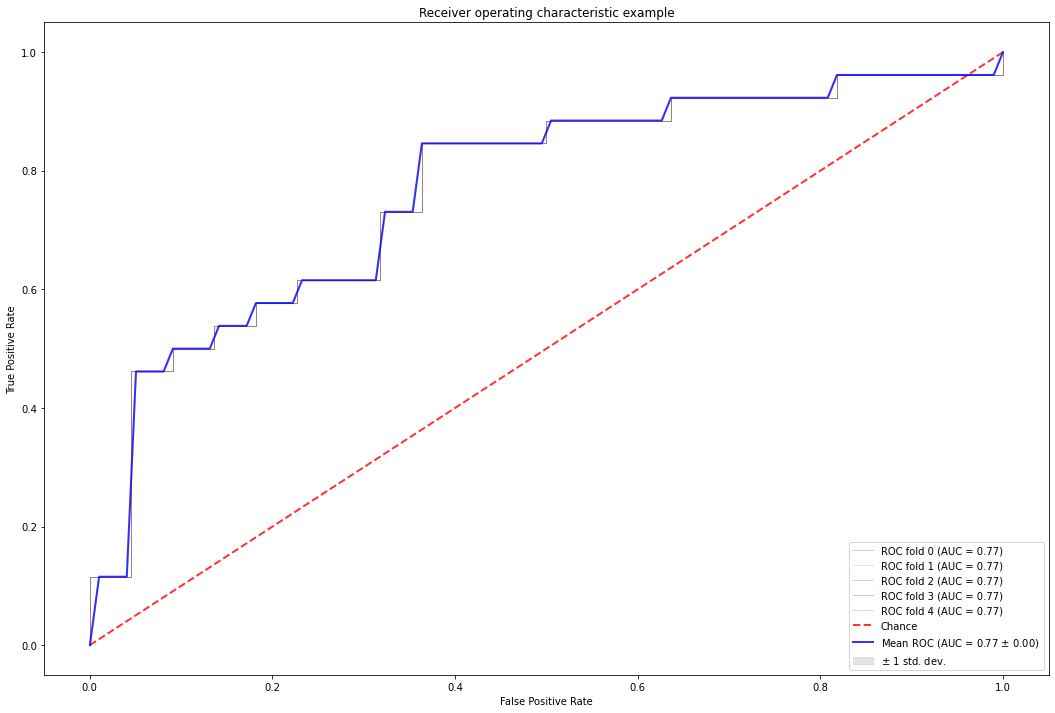

In [27]:
# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=5)
classifier_svc = svm.SVC(kernel='linear', probability=True,
                     random_state=42)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 3 , box.height * 3])
for i, (train, test) in enumerate(cv.split(X_train, y_train)):
    clf_svc = SVC(kernel='linear').fit(X_train, y_train)
    y_pred = clf_svc.predict(X_test)
    viz = plot_roc_curve(clf_svc, X_test, y_test,
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic example")
ax.legend(loc="lower right")
plt.show()

In [28]:
# Classification Report
report_svc = classification_report(y_test, y_pred, output_dict = True)
accuracy_score(y_pred, y_test)

0.6666666666666666

[[ 9 13]
 [ 3 23]]


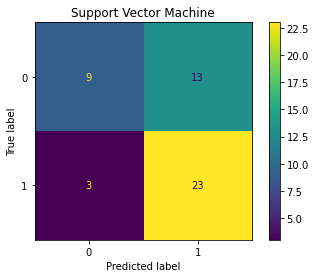

In [29]:
disp = plot_confusion_matrix(clf_svc, X_test, y_test, normalize=None) # attenzione all'argomento "normalize".
disp.ax_.set_title ("Support Vector Machine" ) 
print(disp.confusion_matrix )
plt.show ()

In [30]:
print(report_svc)

{'0': {'precision': 0.75, 'recall': 0.4090909090909091, 'f1-score': 0.5294117647058824, 'support': 22}, '1': {'precision': 0.6388888888888888, 'recall': 0.8846153846153846, 'f1-score': 0.7419354838709676, 'support': 26}, 'accuracy': 0.6666666666666666, 'macro avg': {'precision': 0.6944444444444444, 'recall': 0.6468531468531469, 'f1-score': 0.635673624288425, 'support': 48}, 'weighted avg': {'precision': 0.6898148148148149, 'recall': 0.6666666666666666, 'f1-score': 0.6445287792536369, 'support': 48}}


## 5.4 Compute the relative significance of each feature

In [31]:
features_names = []
for idx1 in range(1,4):
    for idx2 in range(1,14):
        features_names.append(str(idx1) + "_" + str(idx2))

In [32]:
len(features_names)

39

In [38]:
clf_svc.coef_[0]

array([ 3.10559786e-02, -8.97126765e-03,  3.87610830e-01, -1.04366422e-03,
        3.60741904e-02, -5.03339010e-01,  4.79661077e-03, -2.38938124e-01,
       -2.83587871e-01, -1.90808977e-02, -4.46165958e-01, -3.52711529e-01,
        2.14192458e-01, -7.33751431e-03, -1.17401474e-02, -9.43833543e-02,
       -1.81307706e-03, -6.39324854e-03, -2.74710561e-01,  4.48783918e-03,
        3.29860645e-01,  3.19385868e-01, -3.00751735e-01,  7.44574664e-02,
        2.71839954e-01,  1.90773738e-01, -1.82885737e-02, -1.18825119e-02,
        9.43370119e-01, -1.13770300e-03, -1.92725978e-02, -1.05608343e+00,
        7.33169991e-03,  3.75568704e-01,  4.20263864e-01, -1.05137136e-01,
        8.75364912e-02,  1.86942987e-01,  2.37365487e-01])

In [33]:
def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()

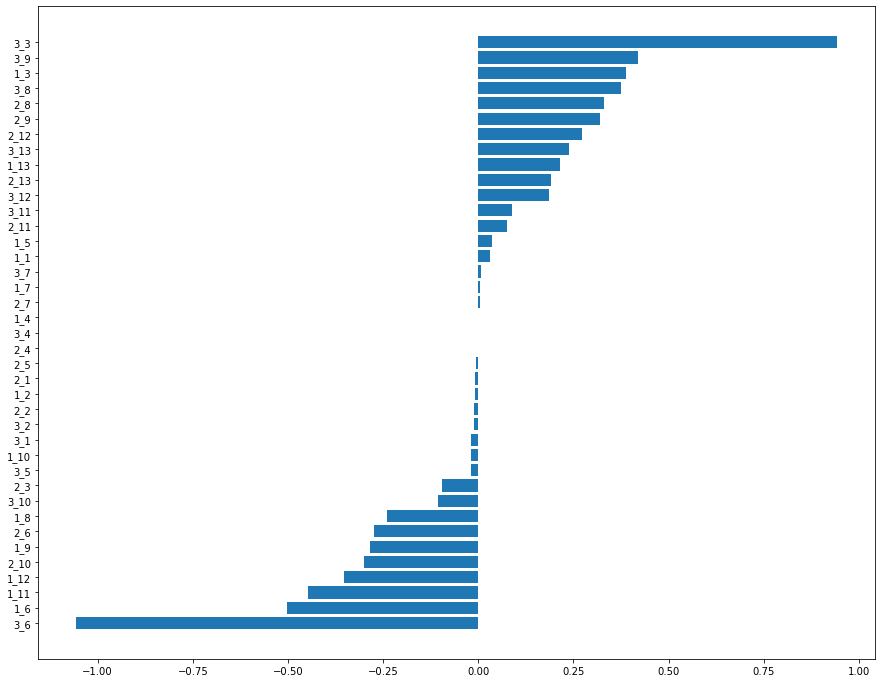

In [40]:
plt.figure(figsize=(15,12))
f_importances(clf_svc.coef_[0], features_names)

# 6. Training the model with 3rd and 6th features

## 6.1 Load the data

In [94]:
pickle_in = open('feat_data.pickle',"rb")
data = pickle.load(pickle_in)

In [95]:
pickle_in = open('labels.pickle',"rb")
labels = pickle.load(pickle_in)

In [96]:
np.mean(data[0][0][:,[2,5]],axis=0)

array([0.72898012, 5.38009193])

In [97]:
lista=[]
for pat in data:
    lista_pat=[]
    for elem in pat:
        mean_elem = np.mean(elem[:,[2,5]],axis=0)
        lista_pat.append(mean_elem)
    lista_pat = np.vstack(lista_pat)
    lista_pat = np.reshape(lista_pat, 6)
    lista.append(lista_pat)

In [98]:
data = np.array(lista)

In [99]:
data.shape

(238, 6)

## 6.2 Train/Test Split

In [100]:
X_train, X_test, y_train, y_test = train_test_split(data, 
                                                    labels, 
                                                    test_size = 0.20, 
                                                    random_state = 22, 
                                                    shuffle = True, 
                                                    stratify = labels)

## 6.3 Modeling

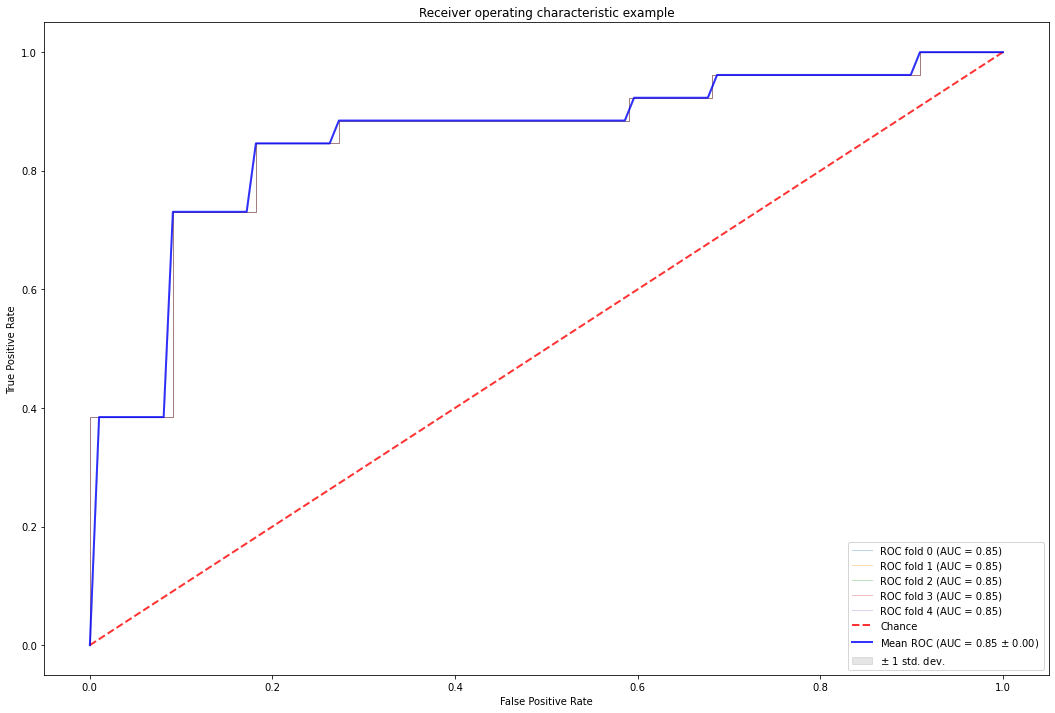

In [101]:
# Run classifier with cross-validation and plot ROC curves
cv = StratifiedKFold(n_splits=5)
classifier_svc = svm.SVC(kernel='linear', probability=True,
                     random_state=42)

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)

fig, ax = plt.subplots()
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 3 , box.height * 3])
for i, (train, test) in enumerate(cv.split(X_train, y_train)):
    clf_svc = SVC(kernel='linear').fit(X_train, y_train)
    y_pred = clf_svc.predict(X_test)
    viz = plot_roc_curve(clf_svc, X_test, y_test,
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic example")
ax.legend(loc="lower right")
plt.show()

In [102]:
# Classification Report
report_svc = classification_report(y_test, y_pred, output_dict = True)
accuracy_score(y_pred, y_test)

0.7291666666666666

[[12 10]
 [ 3 23]]


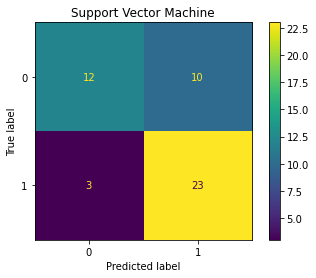

In [103]:
disp = plot_confusion_matrix(clf_svc, X_test, y_test, normalize=None) # attenzione all'argomento "normalize".
disp.ax_.set_title ("Support Vector Machine" ) 
print(disp.confusion_matrix )
plt.show ()

In [104]:
print(report_svc)

{'0': {'precision': 0.8, 'recall': 0.5454545454545454, 'f1-score': 0.6486486486486486, 'support': 22}, '1': {'precision': 0.696969696969697, 'recall': 0.8846153846153846, 'f1-score': 0.7796610169491526, 'support': 26}, 'accuracy': 0.7291666666666666, 'macro avg': {'precision': 0.7484848484848485, 'recall': 0.715034965034965, 'f1-score': 0.7141548327989006, 'support': 48}, 'weighted avg': {'precision': 0.7441919191919192, 'recall': 0.7291666666666666, 'f1-score': 0.7196136814780881, 'support': 48}}


#### Create the names for the variables

In [105]:
features_names = ["1_3", "1_6","2_3", "2_6","3_3", "3_6"]

In [108]:
def f_importances(coef, names):
    imp = coef
    imp,names = zip(*sorted(zip(imp,names)))
    plt.barh(range(len(names)), imp, align='center')
    plt.yticks(range(len(names)), names)
    plt.show()

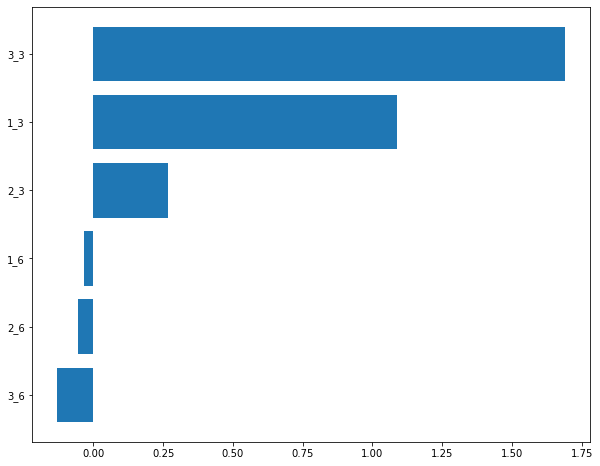

In [109]:
plt.figure(figsize=(10,8))
f_importances(clf_svc.coef_[0], features_names)